# Flats
Interactive visualization and data analysis notebook. There's no model training here, instead this tool is supposed to be used against the parsed database, especially its table **flats**.

In [22]:
from warnings import filterwarnings
from pandas import read_sql
from seaborn import distplot, countplot, scatterplot, heatmap
from matplotlib.pyplot import style, rcParams, subplots
from tabulate import tabulate
from sqlalchemy import create_engine
from os import environ
from scipy.stats import zscore
from numpy import abs, exp
from ppscore import matrix

In [23]:
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='numpy.ufunc size changed')
%matplotlib inline
style.use('dark_background')
rcParams['figure.facecolor'] = '#111111'
rcParams['axes.facecolor'] = '#111111'
rcParams['axes.edgecolor'] = '#212121'
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#212121'
rcParams['legend.frameon'] = False
colors = [
    '#ffa6b0', 
    '#ff7383',
    '#e02f44',
    '#deb6f2',
    '#ca95e5',
    '#a352cc',
    '#c0d8ff',
    '#8ab8ff',
    '#3274d9'
]

In [24]:
engine = create_engine(environ['RAMPART_DATABASE_DSN'])
with engine.connect() as connection:
    flats = read_sql(
        '''
        select id,
               price,
               total_area,
               living_area,
               kitchen_area,
               room_number,
               floor,
               total_floor,
               case
                   when housing = 'primary' then 0
                   else 1
                   end     as housing,
               ssf,
               izf,
               gzf
        from flats
        where city = 'Київ'
        ''',
        connection,
        index_col=['id']
    )
most_flats = flats[(abs(zscore(flats)) < 2).all(1)]

In [25]:
interests = ['price', 'total_area', 'room_number', 'floor', 'total_floor', 'ssf', 'izf', 'gzf']

In [26]:
def render(frame):
    print(tabulate(frame, headers='keys', tablefmt='psql', numalign='right'))

In [27]:
render(flats[interests].head(10))

+------+---------+--------------+---------------+---------+---------------+---------+----------+----------+
|   id |   price |   total_area |   room_number |   floor |   total_floor |     ssf |      izf |      gzf |
|------+---------+--------------+---------------+---------+---------------+---------+----------+----------|
|    7 |  114000 |           98 |             3 |      17 |            17 | 6.78635 |  2.30436 |  0.12277 |
|    8 |  249000 |           71 |             3 |      12 |            26 |  5.4816 |  2.43574 |  1.45123 |
|   10 |  145000 |           55 |             2 |      18 |            20 | 7.54528 |  1.50954 | 0.796041 |
|   13 |   45000 |           24 |             1 |       7 |            13 | 2.15915 |  8.40124 |   1.8871 |
|   14 |   80000 |         77.6 |             3 |      14 |            20 |       0 | 0.777604 | 0.804827 |
|   25 |  165000 |           50 |             2 |      12 |            30 |  4.6797 |  3.49501 |  1.81935 |
|   18 |  258748 |        92

In [28]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 7 to 10054
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         1858 non-null   float64
 1   total_area    1858 non-null   float64
 2   living_area   1858 non-null   float64
 3   kitchen_area  1858 non-null   float64
 4   room_number   1858 non-null   int64  
 5   floor         1858 non-null   int64  
 6   total_floor   1858 non-null   int64  
 7   housing       1858 non-null   int64  
 8   ssf           1858 non-null   float64
 9   izf           1858 non-null   float64
 10  gzf           1858 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 174.2 KB


In [29]:
render(flats[interests].describe())

+-------+---------+--------------+---------------+---------+---------------+---------+---------+----------+
|       |   price |   total_area |   room_number |   floor |   total_floor |     ssf |     izf |      gzf |
|-------+---------+--------------+---------------+---------+---------------+---------+---------+----------|
| count |    1858 |         1858 |          1858 |    1858 |          1858 |    1858 |    1858 |     1858 |
| mean  |  221725 |      92.2186 |       2.39074 | 10.4645 |       18.9962 | 3.78802 | 3.15875 |  2.51824 |
| std   |  276926 |      56.7168 |       1.12549 |  7.0726 |       7.83592 | 4.04096 | 4.81382 |  3.42233 |
| min   |   14000 |           20 |             1 |       1 |             2 |       0 |       0 |        0 |
| 25%   |   84836 |        54.85 |             2 |       4 |            13 |  1.3297 |  1.0046 | 0.796041 |
| 50%   |  138650 |           80 |             2 |       9 |            21 |  3.1253 | 2.43744 |    1.674 |
| 75%   |  250000 |         

In [30]:
print(f'Quite affordable flat amount: {len(flats[(flats["price"] <= 100000) & (flats["ssf"] >= 2) & (flats["gzf"] >= 2)])} / {len(flats)} .')

Quite affordable flat amount: 143 / 1858 .


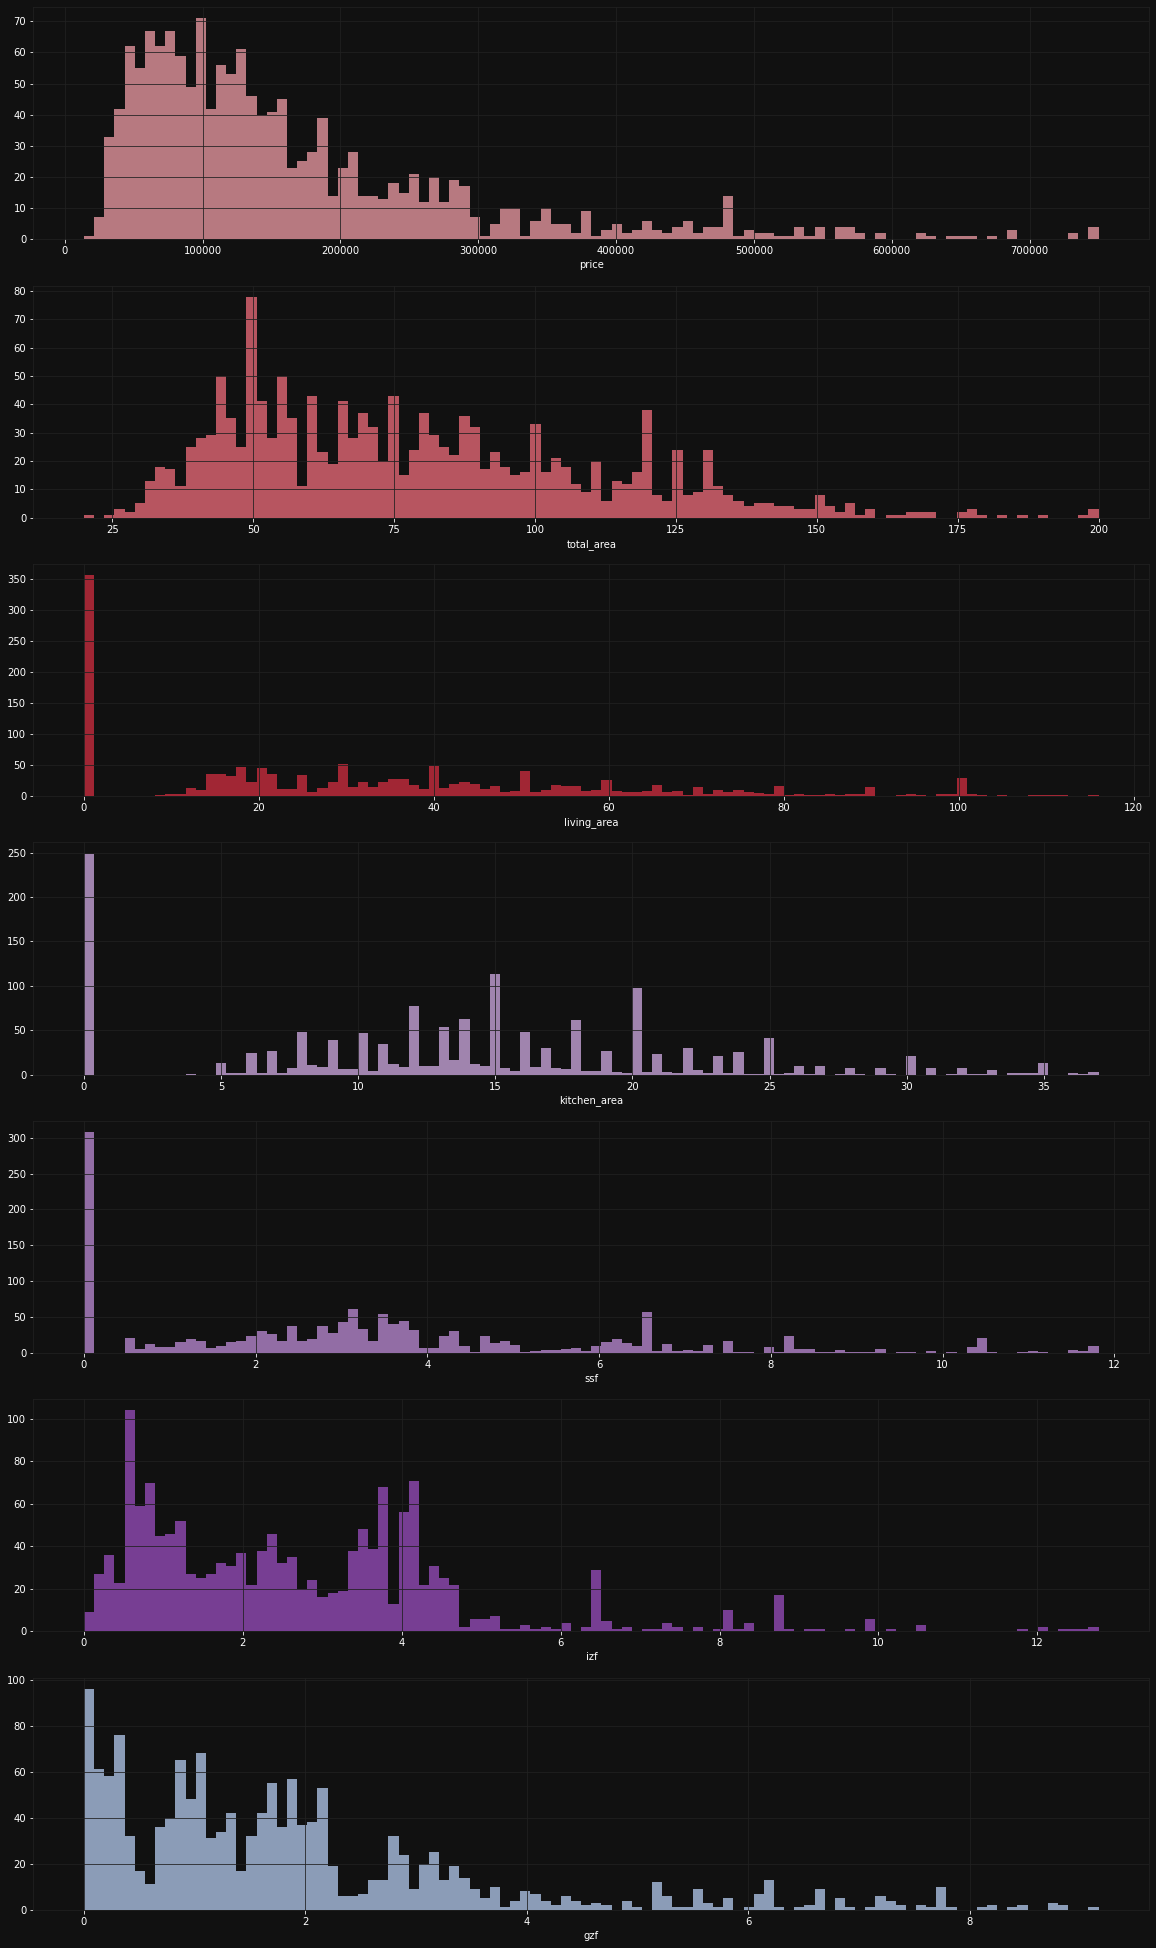

In [31]:
floats = most_flats.select_dtypes(include='float64')
axes = subplots(len(floats.columns), figsize=(20, 5 * len(floats.columns)))[1]
for i, column in enumerate(floats.columns):
    distplot(floats[column], ax=axes[i], color=colors[i], bins=100, kde=False, hist_kws={'alpha': 0.7})

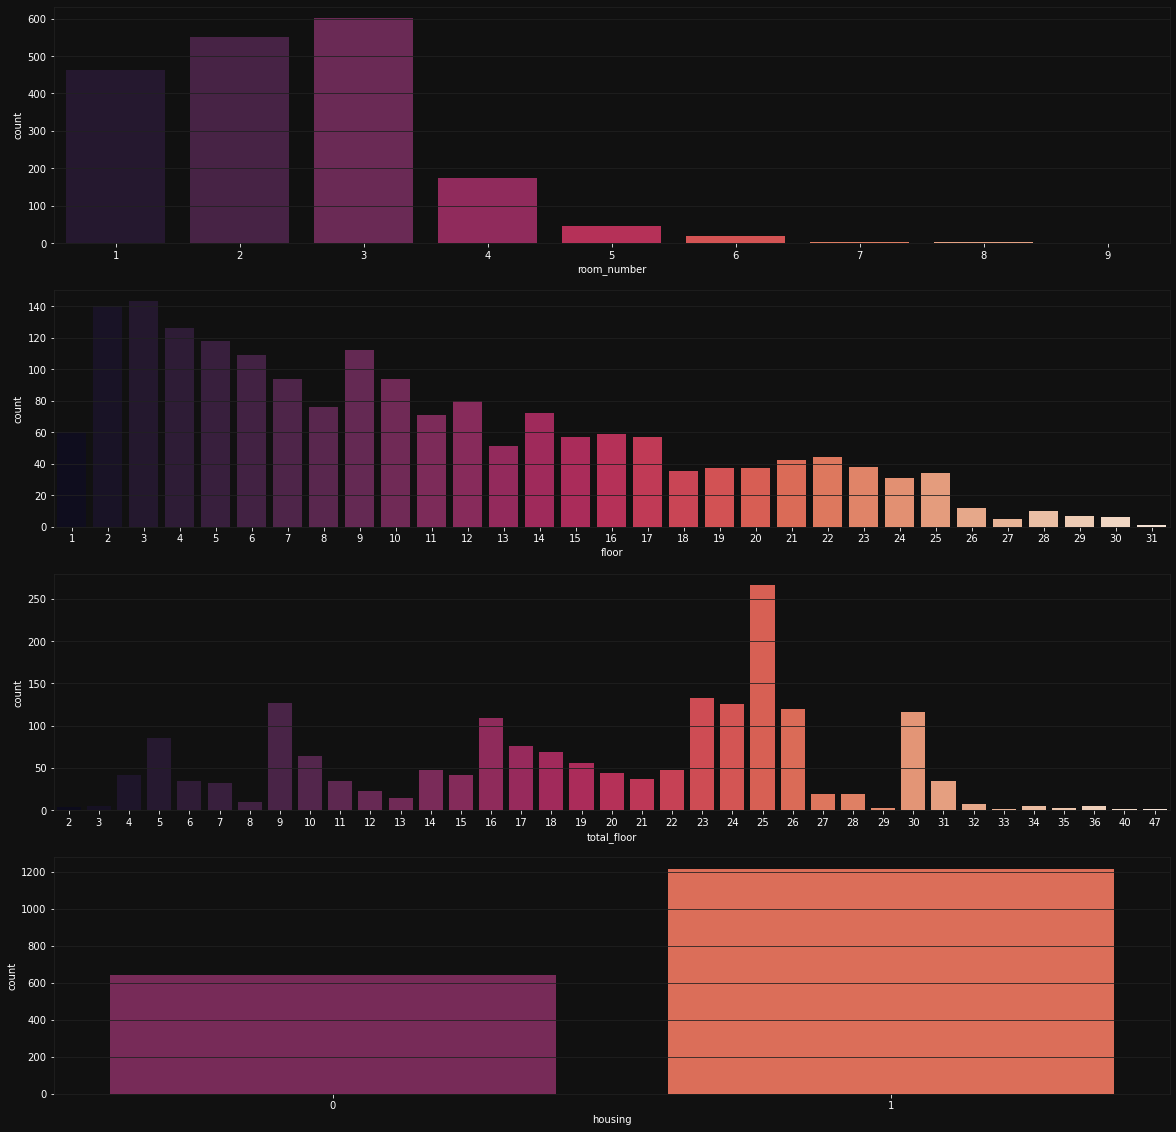

In [32]:
ints = flats.select_dtypes(include='int64')
axes = subplots(len(ints.columns), figsize=(20, 5 * len(ints.columns)))[1]
for i, column in enumerate(ints.columns):
    countplot(flats[column], palette='rocket', ax=axes[i])

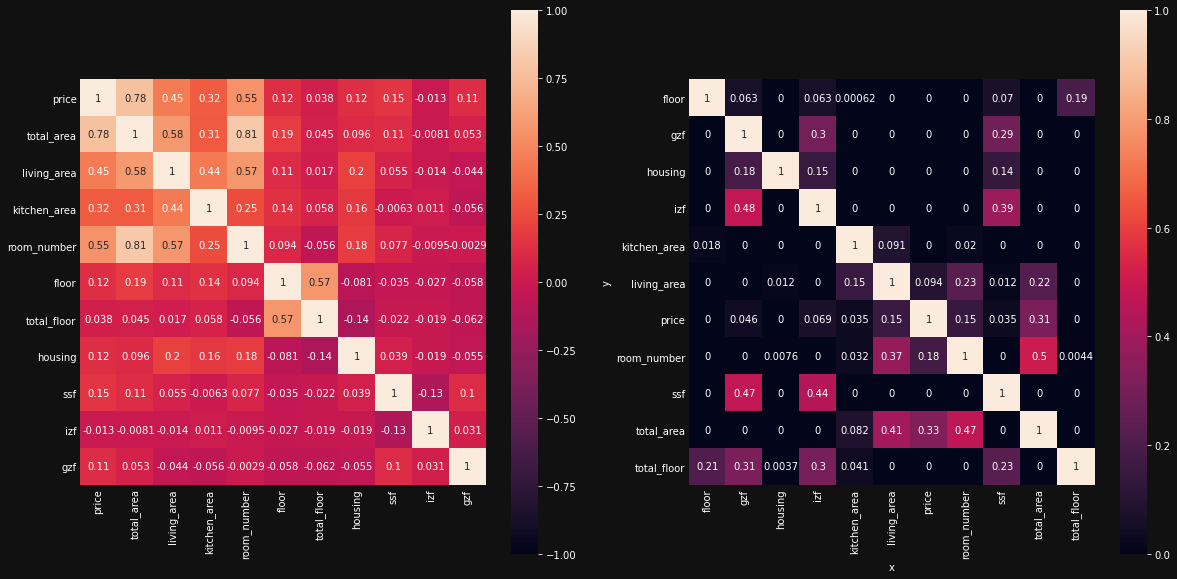

In [33]:
axes = subplots(1, 2, figsize=(20, 10))[1]
for axis in axes:
    axis.tick_params(axis='both', which='both',length=0)
heatmap(
    flats.corr(),
    ax=axes[0],
    vmin=-1,
    vmax=1,
    annot=True,
    square=True,
    cmap='rocket'
)
heatmap(
    matrix(flats)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore'),
    ax=axes[1],
    vmin=0,
    vmax=1,
    annot=True,
    square=True,
    cmap='rocket'
)
pass

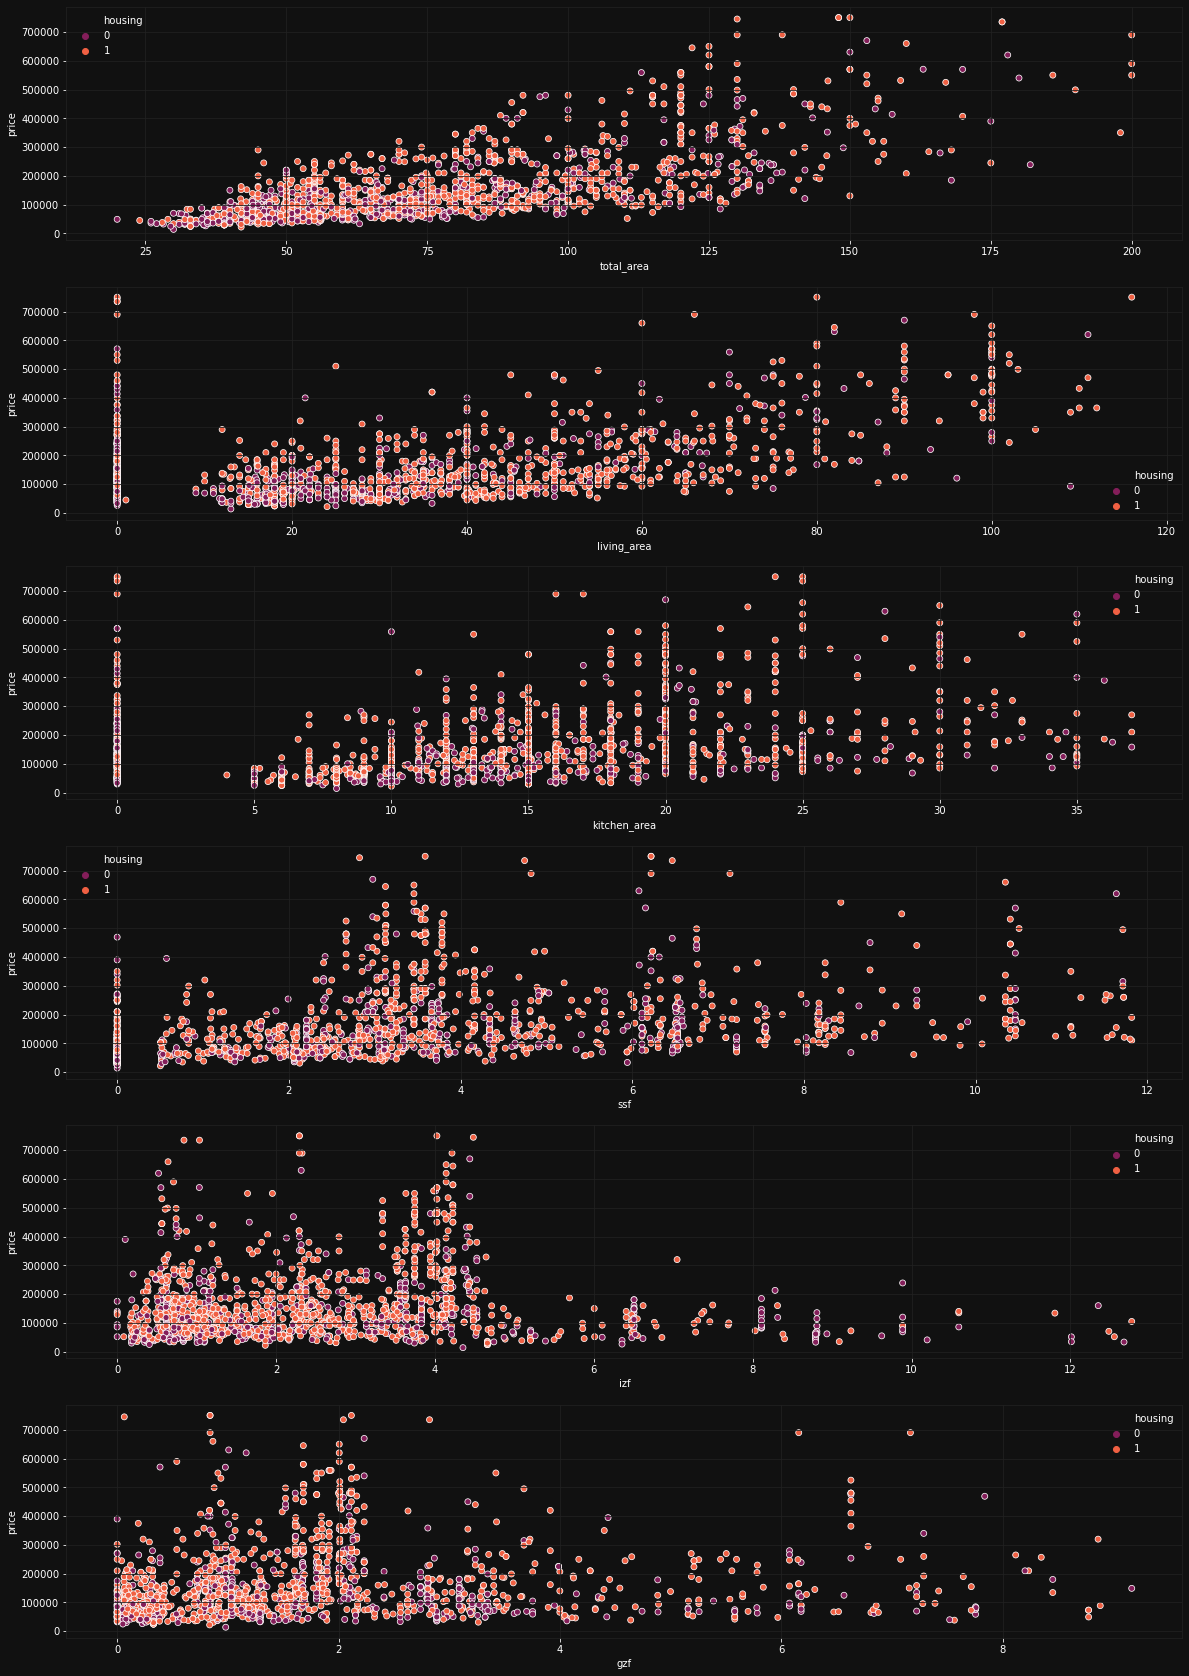

In [34]:
columns = ['total_area', 'living_area', 'kitchen_area', 'ssf', 'izf', 'gzf']
axes = subplots(len(columns), figsize=(20, len(columns) * 5))[1]
for i, column in enumerate(columns):
    scatterplot(column, 'price', 'housing', ax=axes[i], data=most_flats, palette='rocket')